### **Results visualization for HC18 segmentation task**

**Description:** In this notebook, we provide the codes for:

1.   The frequency heatmaps (figure 3 of the report) 
2.   The linear regression and regression weights table 
3.   The accuracy vs epochs plots (figure 4 of the report)
5.   The validation accuracy vs frequency error at index 5 (figure 5 of the report)



**STEP 0 - Loading and averaging training results**

In [10]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')


mainpath = '/content/drive/MyDrive/OptML_Data/Results/Summary_per_seed/Logistic_loss epochs=100 val seed = 0/'
paths = ['/Unet_SGD_batch=5/',
        '/Unet_Adam_batch=5/',
        '/Unet_AdaHessian_batch=5/',
        '/Unet_SCRN(r=5)_batch=5/']


NAME = [] # method name (i.e SGD, Adam...)
Ferr = [] # frequency errors per epoch
ACC_V = [] # validation accuracy for each method
ACC_T = [] # training accuracy for each method


for k in range(len(paths)):

  # We automatically extract the method's name from path name
  path = mainpath+paths[k]
  name = path.split('/')[-2].replace('(r=5)','')
  name = name.split('_')[1]

  print(name)

  # The seed 3 is excluded for SCRN as explaine in section III-C of the report
  if 'SCRN' in name:
    seeds = [0,1,2,4]
  else:
    seeds = [0,1,2,3,4]

  ferr,accuracy_v,accuracy_tr = [0,0,0]

  # Averaging results over seeds
  for seed in seeds:

    path_ = path.replace('seed = 0','seed = '+str(seed))

    epoch_tr = np.load(path_+'epoch_tr.npy') #ensures we follow the correct epochs order
    ferr  +=np.load(path_+'FP.npy')[np.argsort(epoch_tr),:]/len(seeds) 
    accuracy_tr += np.load(path_+'accuracy_tr.npy')[np.argsort(epoch_tr)]/len(seeds)

    epoch_v = np.load(path_+'epoch_v.npy')
    accuracy_v += np.load(path_+'accuracy_v.npy')[np.argsort(epoch_v)]/len(seeds)
    

  NAME.append(name)
  Ferr.append(ferr)
  ACC_V.append(accuracy_v)
  ACC_T.append(accuracy_tr)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SGD
Adam
AdaHessian
SCRN


**STEP 1 - Heatmap functions**

In [11]:
import seaborn as sns; sns.set_theme()
sns.set_context("notebook",  rc={"lines.linewidth": 1})
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def format_frequency(freq_map, epoch_0=0,epoch_f=100,frec_index_0=0,freq_index_f=10):

    '''Function helper to select epochs range and frequency ranges

    freq_map: frequency errors to plot as a heatmap

    return: numpy array
    (freq errors at epochs and indexs selected)
    '''
    F = freq_map.copy()

    if epoch_0!=0:
        F = F[epoch_0:epoch_f,:]
        if frec_index_0!=0:
          F = F[:,frec_index_0:freq_index_f]
        else:
          F = F[:,:freq_index_f]
    else:
        F = F[:epoch_f,:]
        if frec_index_0!=0:
          F = F[:,frec_index_0:freq_index_f]
        else:
          F = F[:,:freq_index_f]

    return F


def plot_Fmap(freq_map, ax, cbar=False, title=''):

  '''Plots the frequency errors over epochs as a heatmap with seaborn.

  freq_map: frequency errors to print
  ax: matplotlib axes
  '''

  # We first ensure to select the right epochs range and frequencies range
  F = np.squeeze(format_frequency(freq_map, epoch_0=0,
                       epoch_f=100,frec_index_0=0,freq_index_f=10)).T

  if cbar:
    # formatting the color bar for the last heatmap
    sns.heatmap(F,  ax=ax, vmin=0, vmax=2,cbar=cbar, label='normal', cbar_kws={'label': '$\Delta$F'}, norm=LogNorm())
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    ax.figure.axes[-1].yaxis.label.set_size(50)

  else:
    sns.heatmap(F,  ax=ax, vmin=0, vmax=2, cbar=False, label='small', norm=LogNorm())

  ax.invert_yaxis()
  ax.set_title(title, fontsize = 70, pad= 80)
  ax.set_xlabel('epoch', fontsize = 60) 
  ax.set_ylabel('frequency index', fontsize = 60)
  ax.tick_params(labelsize = 30)

  xticks=ax.xaxis.get_major_ticks()
  for i in range(len(xticks)):
      if i%10==0:
        continue
      else:
          xticks[i].set_visible(False)


def plot_barplots(models_name, models_Ferr,
                  savepath='/content/drive/MyDrive/OptML_Data/Results/Figures/HEATMAPS.svg'):
  
  ''' Plots the heatmaps for all the optimization methods and save

  models_name: list with methods tags
  models_Ferr: list with frequency errors
  '''

  fig, axs = plt.subplots(1, 4,  figsize=(100,20))

  for k in range(len(NAME)):

    name = models_name[k]
    F = np.squeeze(models_Ferr[k])

    plot_Fmap(F, axs[k],  cbar=(k==3), title=name)
    plt.subplots_adjust(wspace=0.08, hspace=0.00)
    plt.grid('on')

  plt.savefig(savepath, bbox_inches='tight', pad_inches=0)

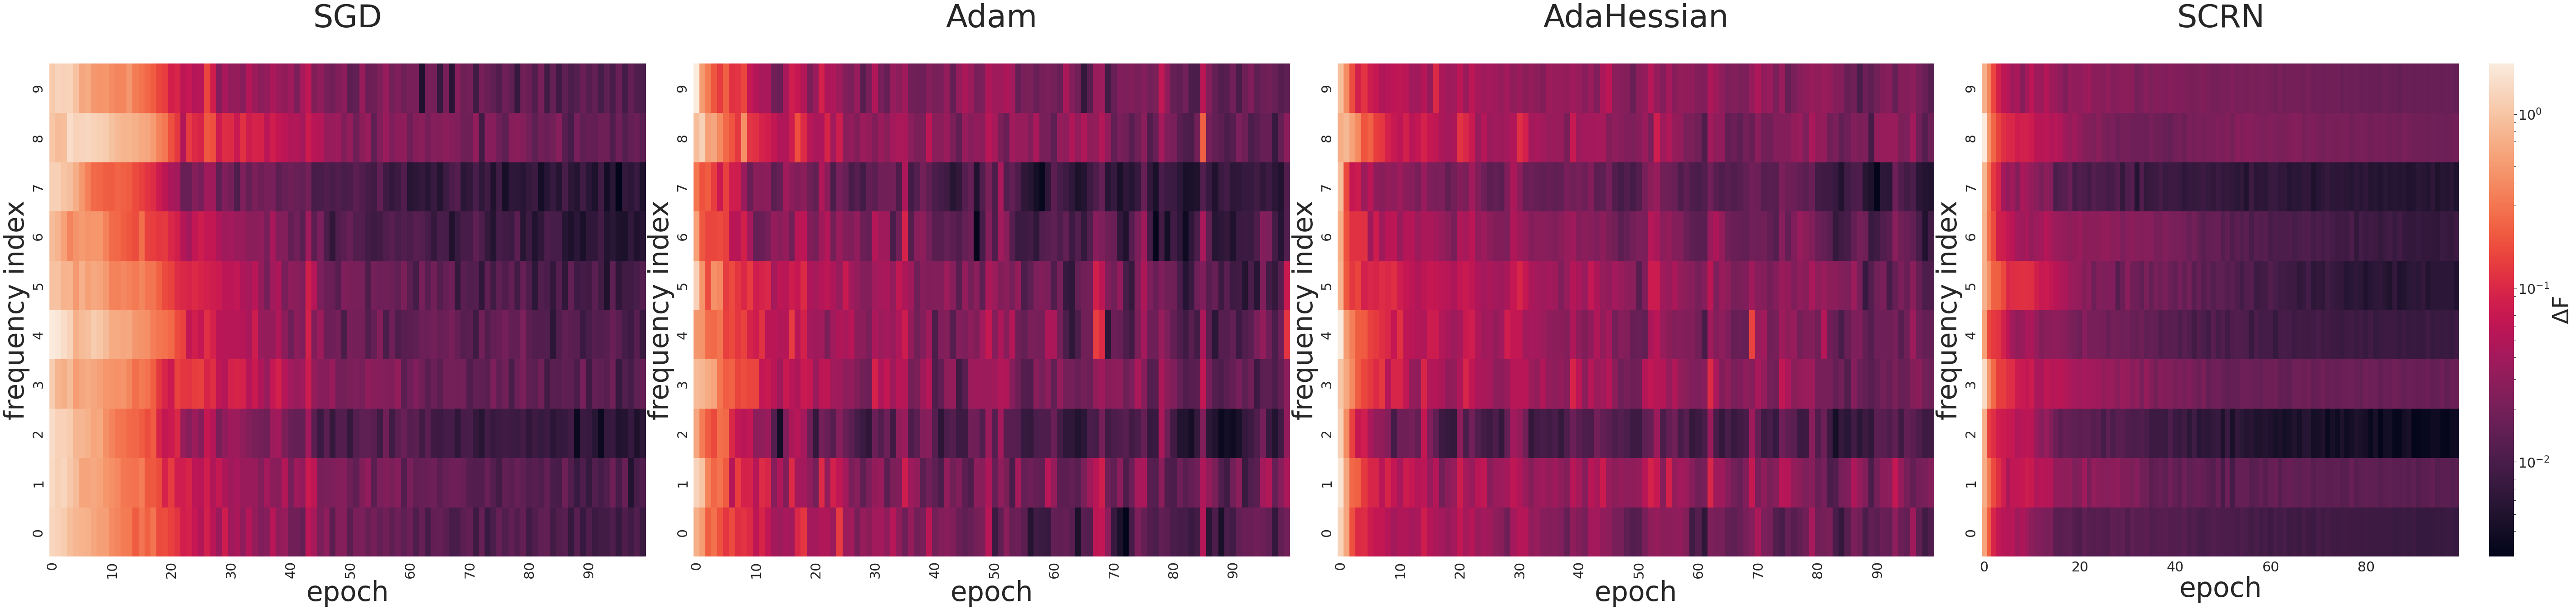

In [13]:
plot_barplots(NAME, Ferr,
              savepath='/content/drive/MyDrive/OptML_Data/Results/Figures/HEATMAPS.svg')

**STEP 2 - Functions for linear regression on the frequency errors to predict validation**

In [42]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy


def print_scores_table(NAME, ACC_V, ACC_T, Ferr, epoch_0=0,epoch_f=100):

  '''Computes the linear regression described in section III-C of the report. 
  NAME: method name, i.e SGD...
  Ferr: frequency errors per epoch for each method (average per seed)
  ACC_V: validation accuracy per epoch for each method (average per seed)
  ACC_T: training accuracy per epoch for each method (average per seed)

  '''

  print('\hline')
  # Store the whole data for regression
  X_ = []
  y_ = []

  for k in range(len(NAME)):

    name = NAME[k]

    # select the epochs range to be considered
    if epoch_0 == 0:
      accuracy_v= ACC_V[k][:epoch_f]
    else:
      accuracy_v= ACC_V[k][epoch_0:epoch_f]

    freq_map = np.squeeze(Ferr[k].copy())
    F = format_frequency(freq_map, epoch_0=epoch_0,
                       epoch_f=epoch_f,frec_index_0=0,freq_index_f=10)
    
    # remove validation outliers based on std
    mu_v = np.mean(accuracy_v); stv = np.std(accuracy_v)
    IsNotOutlier = (accuracy_v>=-stv+mu_v) 

    F = np.squeeze(F[np.argwhere(IsNotOutlier),:])
    accuracy_v = np.squeeze(accuracy_v[np.argwhere(IsNotOutlier)])

    X_.append(F)
    y_.append(accuracy_v)

  # Lasso regression
  regr = linear_model.Lasso(alpha=0.01) 
  
  # standardization
  X = np.concatenate(X_,axis=0)
  y = np.concatenate(y_)
  mean_ = np.mean(X,axis=0)[np.newaxis,:]
  std_ = np.std(X,axis=0)[np.newaxis,:]
        
  X_st = (X - mean_)/(std_+1e-6)
  y_st = (y - np.mean(y))/(np.std(y)+1e-6)

  # Apply Lasso
  regr.fit(X_st,y_st)

  # Extracting the relative weights
  freqs_ratio = np.round(regr.coef_/np.max(np.abs(regr.coef_)), decimals=3) 
  regr_score = regr.score(X_st,y_st)

  # print for direct copy in LateX
  print_str = ''
  for sc,score in enumerate(freqs_ratio):
      if score > 0 :
        color = ' \cellcolor{red!25} '
      else:
        if score < 0:
          color=' \cellcolor{green!25} '
        else:
          score = int(score)
          color=''
      print_str += ' & ' + color + str(score)

  print('All & ', str(np.round(regr_score, decimals=3)),print_str, chr(92),chr(92))
  print('\hline')

In [43]:
print_scores_table(NAME, ACC_V, ACC_T, Ferr, epoch_0=30,epoch_f=100)

\hline
All &  0.344  &  \cellcolor{red!25} 0.292 &  \cellcolor{red!25} 0.664 &  \cellcolor{green!25} -0.157 &  \cellcolor{green!25} -0.258 &  \cellcolor{green!25} -0.241 &  \cellcolor{red!25} 1.0 &  \cellcolor{green!25} -0.655 &  \cellcolor{red!25} 0.61 & 0 &  \cellcolor{red!25} 0.285 \ \
\hline


**STEP 3 - Functions for accuracy plots**

In [6]:
def plot_accuracies(NAME, ACC_V, ACC_T, epoch_0=0,epoch_f=100):


    '''Plots the Appendix function 5 of the report. 
    NAME: method name, i.e SGD...
    Ferr: frequency errors per epoch for each method (average per seed)
    ACC_V: validation accuracy per epoch for each method (average per seed)
    index: the frequency index against which the accuracy is visualized 
    '''

    fig, axs = plt.subplots(2, 1, sharey=True, sharex=False, figsize=(10,10))
    names = []

    for k in range(len(NAME)):

      names.append(NAME[k])

      # select the epochs range to be considered
      if epoch_0 == 0:
        accuracy_tr= ACC_T[k][:epoch_f]
      else:
        accuracy_tr= ACC_T[k][epoch_0:epoch_f]

      axs[0].plot(accuracy_tr,'-x')
      
    minor_ticks = np.arange(epoch_0,epoch_f, 10)
    axs[0].set_xticks(minor_ticks)
    axs[0].legend(names)
    axs[0].grid('on')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('accuracy train')

    names = []

    for k in range(len(NAME)):

      names.append(NAME[k])

      # select the epochs range to be considered
      if epoch_0 == 0:
        accuracy_v= ACC_V[k][:epoch_f]
      else:
        accuracy_v= ACC_V[k][epoch_0:epoch_f]

      axs[1].plot(accuracy_v,'-*')
      
    minor_ticks = np.arange(epoch_0,epoch_f, 10)
    axs[1].set_xticks(minor_ticks)

    axs[1].legend(names)
    axs[1].grid('on')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy val')
    plt.ylim([0.85,1])

    file_ = '/content/drive/MyDrive/OptML_Data/Results/Figures/ACC_plots.svg'
    plt.savefig(file_, bbox_inches='tight', pad_inches=0)
    plt.show()

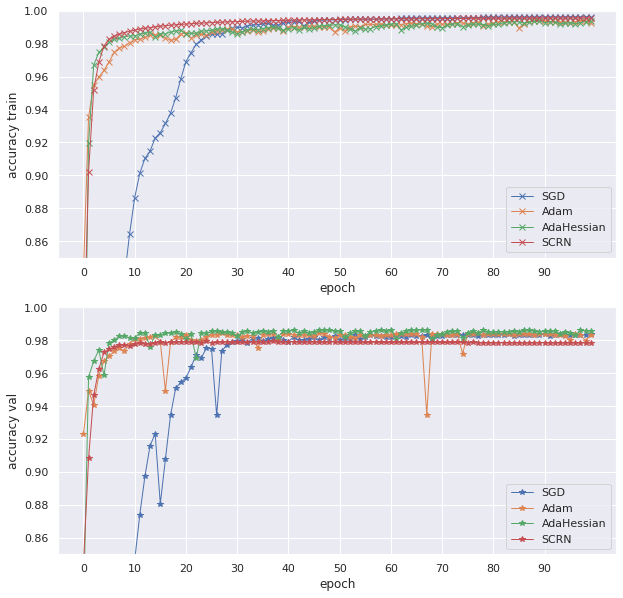

In [7]:
plot_accuracies(NAME, ACC_V, ACC_T, epoch_0=0,epoch_f=100)

**STEP 4 - Function to visualize val accuracy against frequency error at some index**

In [8]:
def plot_freq(NAME, ACC_V, Ferr, index, epoch_0=0,epoch_f=100):


  '''Plots the Appendix function 5 of the report. 
  NAME: method name, i.e SGD...
  Ferr: frequency errors per epoch for each method (average per seed)
  ACC_V: validation accuracy per epoch for each method (average per seed)
  index: the frequency index against which the accuracy is visualized 
  '''

  fig, axs = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(5,5))

  X_ = []
  y_ = []

  for k in range(len(NAME)):

    name = NAME[k]

    # select the epochs range to be considered
    if epoch_0 == 0:
      accuracy_v= ACC_V[k][:epoch_f]
    else:
      accuracy_v= ACC_V[k][epoch_0:epoch_f]

    freq_map = np.squeeze(Ferr[k].copy())
    F = format_frequency(freq_map, epoch_0= epoch_0,
                       epoch_f=epoch_f,frec_index_0=0,freq_index_f=10)
    F = F[:,index]

    # remove validation outliers based on std
    mu_v = np.mean(accuracy_v); stv = np.std(accuracy_v)
    IsNotOutlier = (accuracy_v>=-stv+mu_v) 
    
    F = F[np.argwhere(IsNotOutlier)]
    accuracy_v = np.squeeze(accuracy_v[np.argwhere(IsNotOutlier)])

    axs.scatter(F,accuracy_v)
    axs.grid('on')
    axs.set_xlabel('frequency error at index '+str(index))
    axs.set_ylabel('validation accuracy')

  axs.legend(NAME)

  file_ = '/content/drive/MyDrive/OptML_Data/Results/Figures/Corr_index={}.svg'.format(index)
  plt.savefig(file_, bbox_inches='tight', pad_inches=0)

  plt.show()

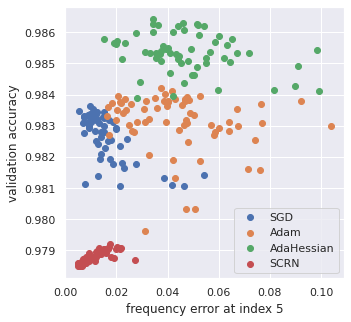

In [9]:
plot_freq(NAME, ACC_V, Ferr, 5, epoch_0=30,epoch_f=100)